In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
knitr::opts_chunk$set(echo = TRUE)

nInd<-175
indIDs <-paste0("X", sample(10000:40000, nInd))
nVisits<-rpois(indIDs, 4)
nVisits[which(nVisits == 0)]<-1

cogAbaseline<-rpois(indIDs, 25)
cogBbaseline<-rnorm(indIDs, 8,4)
cogCbaseline<-rnorm(indIDs, 20, 2)
sex<-sample(c("M", "F"), nInd, replace = TRUE, prob = c(0.55, 0.45))
age<-floor(runif(nInd, 20, 60))
intervention<-sample(c("Placebo", "Training"), nInd, replace = TRUE)
yearsEd<-sample(c(12,14,17), nInd, replace = TRUE, prob = c(0.3,0.4, 0.3))
smoke <- sample(c("Yes", "No"), nInd, replace = TRUE, prob = c(0.25,0.75))
physicalWellbeing <- sample(c("High", "Low"), nInd, replace = TRUE, prob = c(0.85,0.15))
mentalWellbeing <- sample(c("High", "Low"), nInd, replace = TRUE, prob = c(0.7,0.3))
cogAbaseline <- cogAbaseline[(physicalWellbeing == "Low" | mentalWellbeing == "Low")]<- rpois(sum((physicalWellbeing == "Low" | mentalWellbeing == "Low")), 22)
cogAbaseline <- cogAbaseline[smoke == "Yes"]<- rpois(sum(smoke == "Yes"), 23)

visitID<-as.factor(rep(indIDs, nVisits))
visitNum <- unlist(lapply(nVisits, seq))

index<-match(visitID, indIDs)
visitSex<-as.factor(sex[index])
visitAge<-age[index]+visitNum
visitIntervention<-as.factor(intervention[index])
visitYearsEd <- yearsEd[index]
visitSmoke <- as.factor(smoke[index])
visitPW <- as.factor(physicalWellbeing[index])
randomIndex<-sample(1:length(index), nInd)
visitPW[randomIndex]<-"Low"
visitMW <-as.factor(mentalWellbeing[index])
randomIndex<-sample(which(visitNum > 3), nInd*0.5)
visitMW[randomIndex]<-"High"
    
cogA<- floor(cogAbaseline[index] + visitNum * (0.2 + 0.05 * as.numeric(visitIntervention) + 0.04 * as.numeric(visitMW)) + rnorm(length(visitNum), 0,2))

cogB<-cogBbaseline[index] + visitNum * (0.1 - 0.08 * as.numeric(visitSex) + 0.05 * (visitYearsEd-12)) + rnorm(length(visitNum), 0, 1) 

cogC<-cogCbaseline[index] + visitNum * (0.01 + 0.003 * as.numeric(visitSex) + 0.001 * as.numeric(visitIntervention)) + rnorm(length(visitNum), 0, 5) 


cogDat<-data.frame("ID" = visitID, "VisitNum" = visitNum, "Age" = visitAge, "Sex" = visitSex, "YearsEducation" = visitYearsEd, "Smoker" = visitSmoke, "Intervention" = visitIntervention, "CognitionA" = cogA, "CognitionB" = cogB, "CognitionC" = cogC, "PhysicalWellbeing" = visitPW, "MentalWellbeing" = visitMW)


# Mixed Effects Models

## Why use a mixed effects model?

Standard linear regression models make the assumption that the data used to fit the model are randomly selected from the population. By randomly we mean that all pairs of samples are equally different. Another way of thinking about this is that there is no reason why knowing the outcome of one sample would make it easier for us to predict the outcome of another sample. This is not always the case, and indeed there are times when we want to use data where there are relationships between the observations or some underlying structure to the data. This might be deliberate and part of the study design e.g. family or longitudinal studies, or alternatively it may be a consequence of poor study design or unforeseen recruitment bias.

If we force a standard regression model that makes this assumption onto these type of data, we run the risk of our results being biased and the wrong conclusion being made. One work around is to filter our data so that it only contains independent samples, but this seems a bit of waste of valuable data that contains additional information that could improve the fit of our model. Instead it would be preferable to use a methodology that can appropriately model the underlying structure.

Multi-level models are designed to deal with nested, grouped, clustered or hierarchical data. These are all synonyms for the same concept that the observations are not independent and there is some underlying structure to the data. This structure may be something you are interested in or just something you want to control for. In genral multi-level models can be considered a more complex regression framework to model:

-   structure within data
    -   e.g. patients recruited by different consultants from different clinics across the UK
-   heterogeneity in variance between groups
    -   e.g. post-code specific effects on risk factors for disease
-   individual-level and group-level effects
    -   e.g. weight influenced by genetics and local access to gyms
-   dependencies between observations
    -   e.g. educational attainment at age 18 influenced by educational attainment at age 12

They are also referred to as mixed effects model, hierarchical linear models, random effects models, random coefficients models, and probably other names.

## What is a mixed effects model?

Standard linear regression models, such as the example below, have one level, and can be referred to as single level regression models, whereby all the data is treated as independent observations.

The formula for a standard linear regression model between two variables can be written as:

$$y_{i} = \beta_{0} + \beta_{1}x_{i} + \varepsilon_{i}$$

Where for observation i:

-   $y_{i}$ is the outcome variable
-   $x_{i}$ is the predictor variable
-   $\beta_{0}$ is the intercept
-   $\beta_{1}$ is the slope coefficient for X
-   $\varepsilon \sim N(0,\sigma^2)$ is the error

Critically all the parameters ($\beta_{0}$, $\beta_{1}$) estimated for this model apply to all observations in the sample. There is a single intercept, and single slope coefficient for each predictor variable, and consequently, a single error term. In order to model structure in our data set, whereby some observations get treated differently, we need to expand this formula and introduce new parameters to represent this grouping effect. We use the variance components model, shown below, to include a group level influence:

$$\beta_{0j} = \beta_{0} + u_{0j}$$

where for observation i, in group j:

-   $\beta_{0j}$ represents the mean intercept for group j
-   $\beta_{0}$ is the overall mean
-   $u_{0j} \sim N(0, \sigma_{u}^2$ is the moderator effect for group j

A multi-level model is the combination of both the single level regression model and variance components model. It can be represented as the two equations above, where each equation represents a different level of the data, i.e. one representing the individual level predictors (level 1) and one representing the group level predictors (level 2). Alternatively, we can write as a single equation, by substituting the level 2 equation into the level 1 equation:

$$y_{ij} = \beta_{0} + u_{0j} + \beta_{1}x_{ij}  + \varepsilon_{ij}$$

From this formula we can see that each group $j$ has it's own intercept value ($\beta_{0} + u_{0j}$) but every observation has the same slope coefficient ($\beta_{1}$). We call this a random intercepts model.

## What are fixed and random effects?

Typically when defining or describing to mixed effects models, we consider them to include both fixed and random effects, where variables are assigned to be modeled as either one or the other. Fixed effects assume that the parameter estimates apply to all our observations (i.e. do not depend on j) and we estimate the value of the regression parameters for each variable. The interpretation of these estimated coefficients is as it was in single level regression models.

Instead for variables classified as having random effects, we are assuming that each group within that variable has it's own effect and that across all the groups the distribution of their effects is normal. For random effects we are interested in estimating the variance of the distribution from which the group effects come. Conceptually random effects must be categorical variables.

For a mixed effects model with one fixed effect and one random effect we have four parameters to estimate using our observed data:

-   $\beta_{0}$ (fixed effect)
-   $\beta_{1}$ (fixed effect)
-   $\sigma^{2}_{u}$ (random effect)
-   $\sigma^{2}_{\varepsilon}$ (random effect)

In [3]:
from jupyterquiz import display_quiz
display_quiz("questions/mixed_effects_models.json")

<IPython.core.display.Javascript object>

## Fitting mixed effects models in R

### The dataset

In [4]:
%%R
head(cogDat)

     ID

 VisitNum

 Age

 Sex

 YearsEducation

 Smoker

 Intervention

 CognitionA


1

 X36948

        1

  40

   M

             12

    Yes

     Training

         24


2

 X36948

        2

  41

   M

             12

    Yes

     Training

         23


3

 X36948

        3

  42

   M

             12

    Yes

     Training

         21


4

 X36948

        4

  43

   M

             12

    Yes

     Training

         26


5

 X36948

        5

  44

   M

             12

    Yes

     Training

         19


6

 X26082

        1

  22

   M

             14

    Yes

     Training

         28

 CognitionB

 CognitionC

 PhysicalWellbeing

 MentalWellbeing


1

   8.907434

   19.55151

              High

            High


2

   8.545244

   25.93143

              High

            High


3

  10.097223

   19.30359

              High

            High


4

   9.718655

   19.17890

              High

            High


5

   7.258144

   17.87744

              High

            High


6

   9.003513

   29.01686

               Low

             Low

To enable us to try out some multilevel regression models we have provided some longitudinal data looking at cognitive performance annually for an intervention study. All individuals have multiple entries capturing data collected at different assessments over time. For each individual we have a unique identifier code (`ID`). We have the individual's sex, smoking status, intervention status and years education. We then have a series of columns for the visit data, which includes scores from various cognitive tests `CognitionA`, `CognitionB`, etc as well their age at the time of assessment and physical or mental well being. We can use the `table()` function to tabulate how many visits each individual had, and then the `summary()` and `hist()` functions to calculate some descriptive statistics and plot a histogram of these data.

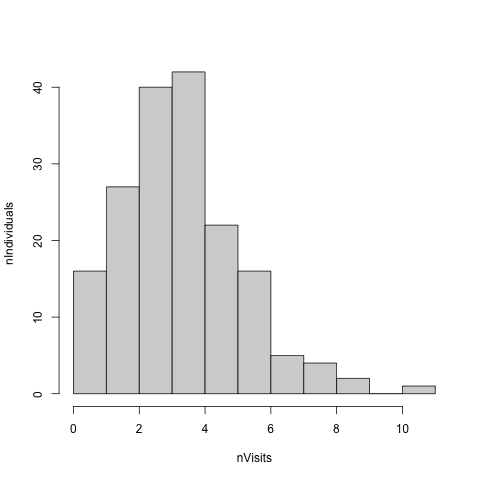

In [5]:
%%R
nVisit<-table(cogDat$ID)
summary(as.numeric(nVisit))

hist(nVisit, main = "", xlab = "nVisits", ylab = "nIndividuals", breaks = c(0:max(nVisit)))

We can see that the majority of individuals had more than one visit, with a mean of `r signif(mean(nVisit),3)` and a maximum of `r max(nVisit)` visits.

Given we have multiple observations from the same person we can not use standard regression models and instead we need to use a mixed effects model, as it is likely that an individual's performance at one visit will predict their performance at a second visit.

The functions to fit a multi-level model are not provided with the standard installation of R so we need to install a package which contains the functions we need. Packages are the fundamental units of reproducible R code and are the mechanism to increase R's usability. They include reusable R functions, the documentation that describes how to use them, and optionally sample data and tutorials. The package we will use here is called `lme4`. First we will cover how to install and load a package.

### Installing and loading packages

There are a number of places R packages can be downloaded from (NB not all packages are available in all locations so the package itself will dictate which method you use to install it). Many older packages are stored on CRAN[<https://cran.r-project.org/web/packages/>]. R provides a function to download such packages `install.packages()` where the name of the package is provided as an argument. Multiple packages can be provided as a vector using the `c()` function. The lme4 package we are interested in, can be installed in this way.


Alternatively in Rstudio, this can be achieved through the drop-down menus: Tools -\> Install Packages... -\> and the package name can be entered (Figure 1). The end of this document contains additional notes on other ways to install packages.

![Figure 1: Install packages in RStudio via dropdown menus](images/installPackages.png)

You may get a pop-up window asking you to choose a mirror (this is not overly important but logical to choose a local UK based mirror). When you install a package some text may be printed to the console, some of which won't be in plain English or easily understandable. You may get a warning say cannot write to the default library directory and R will suggest an alternative which you can choose to accept. Ultimately you should get a message saying `package 'lme4' successfully unpacked and MD5 sums checked` indicating the installation has worked, it should also tell you where it has installed the package. This information is not important, as it will automatically install it where R can find it, and you shouldn't need to to look at these files. Packages typically build on functionality from other packages and cannot be successfully installed if any packages it depends on are not installed on your system. By default these should be automatically installed along with the package you want. However errors may arise if the packages are hosted in different places and therefore cannot all be installed using the same command. See the end of this document for other methods to install packages from other repositories.

Once we have installed the package we need to load it. As with all other software you install on a computer, it only needs to be installed once and in future R sessions you just need to load the package as follows. The caveat here is if you update the version of R you are using, as the packages are saved in folders relating to the version of R you are using.


From the output you can see that it automatically loads any other packages it is dependent on, in this case the Matrix package.

All packages hosted on CRAN come with a webpage which provides a description of what the package does, details on the version number, who wrote the package and other useful information. All packages also come with a manual which documents all the functions the package contains and some will also have vignettes providing an annotated typical workflow for using the package. These are put together by the package authors and therefore can be variable in how accessible the language is and useful the information is for users. Links to the manual and vignette can be accessed through the package's webpage. The documentation for each function can also be accessed through the help function in R. To fit a mixed effects model we will use the function `lmer`, but before we use it let's see what the help function has to say about it.

In [6]:
%%R
library("lme4")
help(lmer)

File: /var/folders/r7/wblx0jw96hz08nvjz9p3zsgr0000gp/T//RtmpIzNUF3/Rtxt43c346b046d4
lmer                   package:lme4                    R Documentation



_F_i_t _L_i_n_e_a_r _M_i_x_e_d-_E_f_f_e_c_t_s _M_o_d_e_l_s



_D_e_s_c_r_i_p_t_i_o_n:



     Fit a linear mixed-effects model (LMM) to data, via REML or

     maximum likelihood.



_U_s_a_g_e:



     lmer(formula, data = NULL, REML = TRUE, control = lmerControl(),

          start = NULL, verbose = 0L, subset, weights, na.action,

          offset, contrasts = NULL, devFunOnly = FALSE)

     

_A_r_g_u_m_e_n_t_s:



 formula: a two-sided linear formula object describing both the

          fixed-effects and random-effects part of the model, with the

          response on the left of a ‘~’ operator and the terms,

          separated by ‘+’ operators, on the right.  Random-effects

          terms are distinguished by vertical bars (‘|’) separating

          expressions for d

Loading required package: Matrix


You may need to update the package in the future. `update.packages()` can be run to update all packages on your system. Note that every time you update your version of R, you will likely need to reinstall all your packages.

## Coding a mixed effects model

We are going to model how the performance in cognitive test A, varies over the course of the study. As we have repeated measures for most individuals in our study, we are going to include a random intercept for individual. This means that each individual can have a different baseline performance, and we can look for a common trend in the change in cognitive performance. The key features of our model are

-   `CognitionA` is our outcome or dependent variable.
-   `VisitNum` is the independent variable that captures time in the study. This will be modelled as a fixed effect and is what we are interested in measuring the effect of.
-   `ID` is our random effect, i.e. the variable which groups assessment data from the same individual together.

We can tell R to fit this model as follows using the `lmer()` function.


In [7]:
%%R
model.rand.int<-lmer(CognitionA ~ VisitNum  + (1 | ID), data = cogDat)

Fixed effects are included using the standard formula notation as used in linear regression models andthe function `lm()`, with the outcome variable on the left and the predictor on the right separated by a `~`. The `1|` notation is how we specify the inclusion of random intercepts. Unlike standard linear regression, there are choices to be made as to what algorithm to use to derive the parameter estimates from the data you have. This decision is more important if you have a small sample size, in larger sample sizes it shouldn't matter too much. The default behaviour in R is to fit a mixed effects regression model using restricted maximum likelihood (REML), which will given unbiased estimates. We can force R to use maximum likelihood by adding the argument `REML = FALSE`.

## Significance testing in mixed effects regression models

We can extract the statistics in a similar manner to linear regression. First, we can use `summary()` to print a nicely formatted output of some of the results and statistics to the console.

In [8]:
%%R
summary(model.rand.int)

Linear mixed model fit by REML ['lmerMod']


Formula:

CognitionA ~ VisitNum + (1 | ID)

   Data:

cogDat

REML criterion at convergence:

676.9

Scaled residuals:

     Min 

      1Q 

  Median 

      3Q 

     Max 

-2.38629 

-0.53396 

 0.02805 

 0.54615 

 1.76433 

Random effects:


 Groups  

 Name       

 Variance

 Std.Dev.

 ID      

 (Intercept)

 25.329  

 5.033   

 Residual

  3.284  

 1.812   

Number of obs: 136, groups: 

ID, 41


Fixed effects:


 Estimate

 Std. Error

 t value


(Intercept)

  21.3931

     0.8534

  25.068


VisitNum   

   0.2169

     0.1302

   1.666


Correlation of Fixed Effects:


 (Intr)


VisitNum

 -0.332

The output is similar to that from a linear regression model, fitted with `lm()`. It starts with a statement of what type of model and the form of the model fitted. It then gives a summary of the algorithm used to estimate the effects. We have a summary of the scaled residuals (errors), the random effects and fixed effects.

You may have noticed that there are no p-values in the fixed effects co-efficients table. Significance testing in mixed effects models is not as straight forward as it is for linear regression. Our objective for significance testing of the fixed effects is the same as for standard regression, to see if there is a relationship between the predictor variable and the outcome. We do this by seeing if the data supports the alternative hypothesis that the regression parameter is non-zero (compared to the null hypothesis that it's value is equal to 0). As they are conceptually the same, test statistics for fixed effects can be calculated in the same way as the estimated value of the parameter divided by it's standard error. To go from a test statistic to a p value we need to know what distribution to use and this is where it gets tricky. The challenge is that it is not obvious what distribution these test statistics should follow, and how many degrees of freedom should be applied. It could be influenced by

-   Number of observations (level 1)
-   Number of groups (level 2)
-   Number of random effects
-   Combination of the above.

So to determine significance we either need to make an approximation for the degrees of freedom or a perform simulations to establish a distribution which we can use to calculate a p-value. There are methods that have been proposed to calculate approximations for the degrees of freedom (e.g. Kenward-Roger, Satterthwaite) such that the t-distribution can be used in a manner similar to standard regression analysis. Crucially though there is no widely accepted method for calculating degrees of freedom exists. The `lme4` package does not calculate p-values for the coefficients on principle [see discussion](https://stat.ethz.ch/pipermail/r-help/2006-May/094765.html).

However, for many this is not a satisfactory conclusion, so a second package `lmerTest` has been developed, which if loaded alongside lme4, adds p-values to the above table. It is worthwhile noting that, there are multiple methods to calculate p-values, and that might introduce some variation in results across software. More importantly the different methods are based on different assumptions and therefore may introduce misleading results if these are not appropriate for your data set.

To use the `lmerTest` functionality, as before we need to install and load this package.


In [9]:
%%R
#install.packages("lmerTest")
library(lmerTest)


Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step



We then have to refit our mixed effects model for the p-values to be calculated.

In [10]:
%%R
model.rand.int<-lmer(CognitionA ~ VisitNum  + (1 | ID), data = cogDat)
summary(model.rand.int)

Linear mixed model fit by REML. t-tests use Satterthwaite's method

 [

lmerModLmerTest

]

Formula:

CognitionA ~ VisitNum + (1 | ID)

   Data:

cogDat

REML criterion at convergence:

676.9

Scaled residuals:

     Min 

      1Q 

  Median 

      3Q 

     Max 

-2.38629 

-0.53396 

 0.02805 

 0.54615 

 1.76433 

Random effects:


 Groups  

 Name       

 Variance

 Std.Dev.

 ID      

 (Intercept)

 25.329  

 5.033   

 Residual

  3.284  

 1.812   

Number of obs: 136, groups: 

ID, 41


Fixed effects:


 Estimate

 Std. Error

      df

 t value

 Pr(>|t|)


(Intercept)

  21.3931

     0.8534

 50.2640

  25.068

   <2e-16

 ***


VisitNum   

   0.2169

     0.1302

 96.7361

   1.666

    0.099

 .  

---
Signif. codes:  

0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Correlation of Fixed Effects:


 (Intr)


VisitNum

 -0.332

We can see from the coefficients table, that R has used the t-distribution to calculate p-values for the fixed effects. By default `lmerTest` uses the Satterwaite approximation to calculate the degrees of freedom for this test (stated at the top of the output, alongside the method for estimating the coefficients). In the results we can see that the `VisitNum` variable is significantly positively associated with the performance in cognitive test A (p = `r signif(summary(model.rand.int)$coefficients["VisitNum",5],2)`). We can interpret the parameter for this variable as we would for a standard regression model, where the value represents the change in the outcome for one unit increase in the predictor variable, i.e. the change in score for cognitive test A for each extra visit. Specifically, participants had a mean increase in score of `r signif(summary(model.rand.int)$coefficients["VisitNum",1],2)` per visit.

We can also extract information about the variables we fitted as random effects. As described above for these, we are estimating parameters of their distribution and specifically the variance of this distribution. For this model, the variance of the individual intercepts is `r signif(as.data.frame(VarCorr(model.rand.int))[1,"vcov"], 3)`. These are hard to attribute much meaning to, but they represent the width of the distribution that the individual effects come from. A larger number implies a wider distribution and consequently more variation in the individual effects.

We can also do significance testing of the random effects, to determine if the random intercept is needed. Just because we conceptualize that there should/might be structure in our data doesn't mean that there is or that it's effects are dramatic enough for us to need to model it. Given the complexities of significance testing a fixed effect in a mixed effects model, if we can get away with a simpler regression model, we should favour that.

The principle behind a random effect is that each group needs it's own value taken from a distribution and the effects of the groups can not be represented by a single value (as they would it is was modelled as a fixed effect). Therefore, our null hypothesis (which equates to the random effects not being necessary) requires there to be no distribution of effects, which would occur if the variance of the distribution was 0. The alternative hypothesis (which equates to random effects being necessary) is that there is a distribution and it has a non-zero variance. These situations can be represented below.

$$H_{null}: \sigma_{u}^2 = 0$$ $$H_{alternative}: \sigma_{u}^2 \neq 0$$

To determine whether we can reject the null hypothesis, we will use the likelihood ratio test to see if the inclusion of the random effect significantly improves the fit of the model. To make this comparison we need to fit a standard linear model with the same fixed effects terms, but omitting the random effect. We can then use the `anova()` function to calculate the test statistics and perform the comparison with the $\chi^2_{1}$ distribution to calculate a p-value.


In [11]:
%%R 
model.lm<-lm(CognitionA ~ VisitNum, data = cogDat)
anova(model.rand.int, model.lm)

Data: cogDat

Models:

model.lm: CognitionA ~ VisitNum

model.rand.int: CognitionA ~ VisitNum + (1 | ID)

 npar

    AIC

    BIC

  logLik

 deviance

  Chisq

 Df

 Pr(>Chisq)


model.lm      

    3

 847.94

 856.68

 -420.97

   841.94


model.rand.int

    4

 684.08

 695.73

 -338.04

   676.08

 165.87

  1

  < 2.2e-16

 ***

---
Signif. codes:  

0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

refitting model(s) with ML (instead of REML)


You will see in the first line of the output, R first refits the random intercepts model with maximum likelihood so that we can perform the likelihood ratio test. It then proceeds to summarise the statistics of the test and provides the p-value from a $\chi^2_{1}$ distribution, which is significant (P = `r signif(anova(model.rand.int, model.lm)[2,8],2)`). Therefore we can conclude that the addition of a random intercept for individual is an important component of the model. Note if we want a more specific p values than 2.2e-16, we can get that by using the fact that the anova output is a matrix and "slicing" the specific element.

In [12]:
%%R
anova(model.rand.int, model.lm)[2,8]

[1]

 5.915128e-38

refitting model(s) with ML (instead of REML)


Note that there is also an inbuilt function to perform a test for significant random effects `ranova()`. Let's try it out.

In [13]:
%%R
ranova(model.rand.int)

ANOVA-like table for random-effects: Single term deletions


Model:

CognitionA ~ VisitNum + (1 | ID)

 npar

  logLik

    AIC

    LRT

 Df

 Pr(>Chisq)


<none>  

    4

 -338.46

 684.93


(1 | ID)

    3

 -421.02

 848.04

 165.11

  1

  < 2.2e-16

 ***

---
Signif. codes:  

0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Looking at the output, we can see two rows, one for each model and the the number of degrees of freedom for the two models is right. If we just look at the p-value it is the same as when we manually coded the anova therefore we might think that we have performed the same analysis. But on closer inspection we can see the log likelihood values and therefore the test statistic are subtly different. This method is in fact using the likelihood statistics from the model fitted using REML, rather than maximum likelihood which is statistically incorrect. We can confirm this by extracting the log likelihood from our lmer model object (which we fitted using REML rather than ML), rather than refitting using maximum likelihood.

In [14]:
%%R
## log likelihood of linear model
logLik(model.lm)

## log likelihood of random intercepts model fitted with REML
logLik(model.rand.int)

'log Lik.' 

-338.4643

 (df=

4

)


Now in reality the results are essentially the same, and indeed they would have been had we used ML to fit our regression model initially. But it may be preferable to use the `anova()` function to explicitly make the model comparisons, so that you can be confident that you know exactly what methods were used.

## Exercise 1

*Let's see if the other cognitive tests also change consistently over time*

Write the R code required, to test using a mixed effects regression model, the following:

1.  Is cognitive test B significantly associated with visit number?
2.  Is cognitive test C significantly associated with visit number?

For each test, is the random intercept necessary?

```{admonition} Solution
:class: dropdown
``` R
model1<-lmer(CognitionB ~ VisitNum  + (1 | ID), data = cogDat)
model1.null <- lm(CognitionB ~ VisitNum, data = cogDat)
summary(model1)
anova(model1, model1.null)

model2<-lmer(CognitionC ~ VisitNum  + (1 | ID), data = cogDat)
model2.null<-lm(CognitionC ~ VisitNum, data = cogDat)
summary(model2)
anova(model2, model2.null)
```
```

In [15]:
from jupyterquiz import display_quiz
display_quiz("questions/mixed_effects_models_exercise.json")

<IPython.core.display.Javascript object>

## Extracting the results

To pull out specific parts of the output we can then use the `$` or use built in functions. We can use `names()` to get a list of all the elements we can extract from the summary object. NB with a linear regression model we extract results using functions applied to the `lm()` output,(e.g `coef(model.lm)`) here we apply functions to the summary output of the `lmer` model (e.g. `coef(summary(model.rand.int))`).


In [16]:
%%R
summary(model.rand.int)$coefficients
names(summary(model.rand.int))

 [1]

 "methTitle"   

 "objClass"    

 "devcomp"     

 "isLmer"      

 "useScale"    

 [6]

 "logLik"      

 "family"      

 "link"        

 "ngrps"       

 "coefficients"

[11]

 "sigma"       

 "vcov"        

 "varcor"      

 "AICtab"      

 "call"        

[16]

 "residuals"   

 "fitMsgs"     

 "optinfo"     

 "corrSet"     

For example we can extract the variance covariance matrix:

In [17]:
%%R
vcov(summary(model.rand.int))

2 x 2 Matrix of class "dpoMatrix"


 (Intercept)

    VisitNum


(Intercept)

  0.72828888

 -0.03687879


VisitNum   

 -0.03687879

  0.01695542

## Graphical representation of random intercept model

When we fit a regression model we are estimating the parameters of a model we have specified that enables us to characterise the relationship between variables. One way we can understand the nature of the graph is to create a plot of it. Let's do that here to visualise what is happening.

To plot the relationship we need to extract the estimates of the parameters of the regression model for both the fixed and random effects. Compare the output of the following two commands.


In [18]:
%%R
coef(summary(model.rand.int))
lapply(coef(model.rand.int), head)

$ID


 (Intercept)

  VisitNum


X10096

    31.04876

 0.2168967


X10410

    19.27637

 0.2168967


X10964

    20.97143

 0.2168967


X11583

    21.55904

 0.2168967


X12230

    25.39334

 0.2168967


X13318

    17.31218

 0.2168967

The first command `coef(summary(model.rand.int))` gives us just the fixed effects along with the test statistics and p-values. From these coefficients we can make predictions for the average individual in the study, from which we can make generalised conclusions.

The second command `coef(model.rand.int)` gives us the intercept and slope values for each level of our grouping variable, one per row. We have only extracted this output for the first six individuals, as otherwise it would run on for pages. This data is stored in a list, where each random variable has it's own slot, within which is a matrix of the regression parameters. As we have only one random variable we have only slot in our list, so it perhaps seems an unnecessary complicated structure, but it is designed to anticipate models with multiple random variables. `lapply()` is a efficiency function in R which allows us to perform the same function to each slot of the list. Here we wanted to run the command `head()` to pull out the first 6 rows, so that we could make the output more manageable and get a sense of what the output looked like.

Note that the intercepts vary for each individual but the coefficients for `VisitNum` do not. These individual level intercept are calculated as the overall mean intercept estimate (`r coef(summary(model.rand.int))["(Intercept)","Estimate"]`) added to the estimated individual specific effects. The slope coefficient is taken just from the fixed effect estimate. This is in line with the fact that we fitted a random intercept model. From this output we can make individual level predictions for the individuals in our observed data, which doesn't have much meaning for individuals not in our study.

With these coefficients we can visualise the results

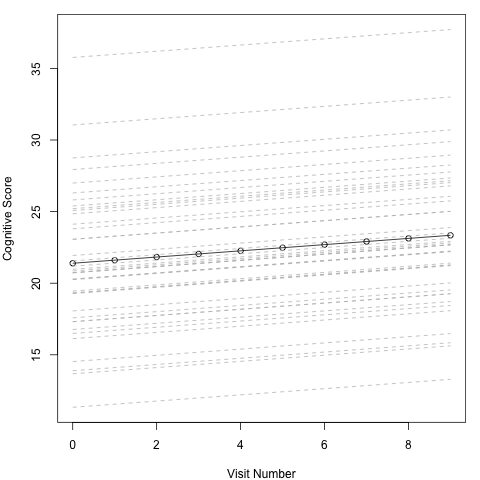

In [19]:
%%R
par(mar = c(4,4,1,1))
# extract model coefficients
ind.effects <- coef(model.rand.int)$ID
mean.effects <- coef(summary(model.rand.int))[,"Estimate"]

# create x variable that covers visit numbers
x.sample <- as.matrix(c(0:9))

# predict outcome using individual level coefficients
y.ind <- ind.effects[,1]+ t(x.sample %*% t(as.matrix(ind.effects[,2])))
# predict outcome using overal mean effect coefficients
y.mean <- mean.effects[1] + x.sample * mean.effects[2]

y_lim <-range(y.ind)
plot(x.sample, y.mean, ylim = y_lim, xlab = "Visit Number", ylab = "Cognitive Score")
for(i in 1:nrow(y.ind)){
    lines(x.sample, y.ind[i,], lty = 2, col = "grey")
}
lines(x.sample, y.mean, ylim = y_lim, xlab = "Visit Number", ylab = "Cognitive Score")

In this plot each dashed grey line represents an individual, while the black solid line represents the overall mean effect. What we can see is that each line starts at a different height on the y axis courtesy of the individual specific intercepts. All the lines are parallel however. The slope of the line is determined by the slope coefficient for `VisitNum` and as this isn't dependent on the random variable there is no variation across individuals. Hence all the lines changes at the same rate. The solid black line falls approximately in the middle, with approximately half on the individual specific lines above and below. This is due to the mean do the distribution of the individual effects being set to 0. The black line tells us about the average individual, and is what we would use to make predictions about an individual outside of this cohort and describe the effect.

## Assumptions for random intercept model

As with all statistical tests, the ability to calculate estimates of the parameters and perform significance testing relies of assumptions about the data you are using. For a random intercepts model these are:

-   Linear relationship between predictors and outcomes.
-   Constant variance across range of predictor variables (homoscedasticity).
-   Errors at every level are normally distributed.
-   The level 1 and level 2 residuals are uncorrelated.
-   The errors at the highest level are uncorrelated.

## Diagnostic plots

There is no automatic way to produce the diagnostic plots like you can from the linear regression function (`lm()`). However we can recreate these plots by extracting the required statistics from the `lmer` model object.

Firstly, we can plot the residuals against the fitted values. In this plot we want the points to be randomly scattered with no evidence of a relationship between the x and y axis. Any evidence of the residuals being related to the fitted values may be indicative of a non-linear relationship between the dependent and independent variables. In this example they look pretty random with no obvious pattern.


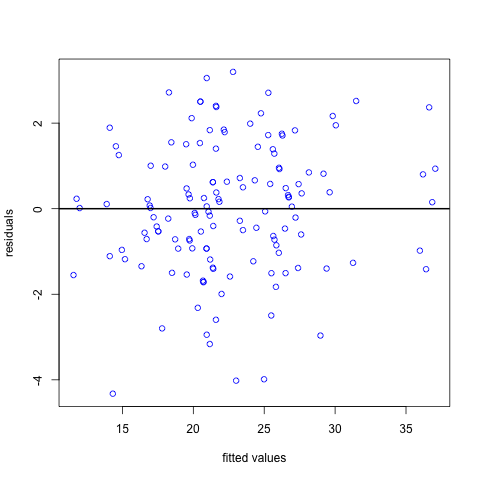

In [20]:
%%R
# a plot to check the constant standard deviation
plot(fitted(model.rand.int),resid(model.rand.int,type="pearson"),col="blue", xlab = "fitted values", ylab = "residuals") 
abline(h=0,lwd=2)

Secondly, we will consider the distribution of the residuals. Similar to linear regression, the residuals are assumed to be normally distributed with constant standard deviation. Therefore we can use a QQ plot to assess this (as well as look at the values provided in the summary of the model fit which should be symmetric and have a median \~ 0). With a qq plot (or quantile-quantile plot), we are looking for the points to follow the diagonal line, any deviation indicates that the data are not normally distributed. In this example it looks pretty good.

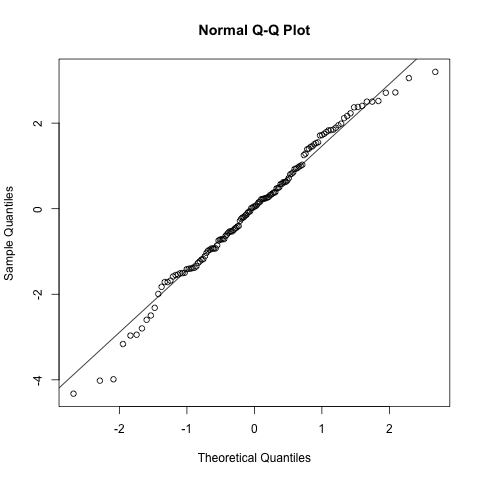

In [21]:
%%R
# normality of the residuals
qqnorm(resid(model.rand.int)) 
qqline(resid(model.rand.int))

Thirdly, an assumption specific to mixed effects models is that the random effects are also normally distributed. Again we can use a qq plot to assess this and it looks good.

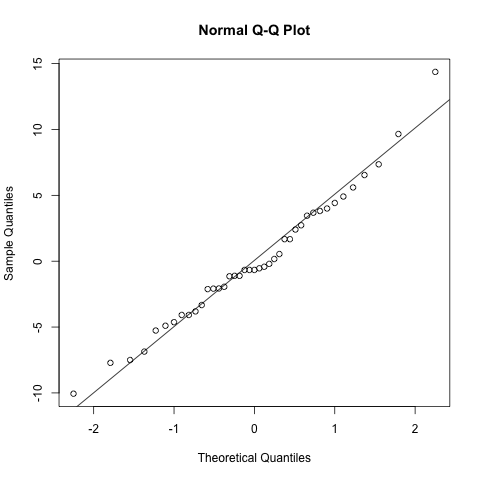

In [22]:
%%R
# normality of the random intercept estimates
qqnorm(ranef(model.rand.int)$`ID`[,1]) 
qqline(ranef(model.rand.int)$`ID`[,1])

## Adding random effects for regression coefficients (random slopes)

As well as individual specific intercepts, perhaps we also think that individuals will have a specific relationship between the predictor and outcome variables. We can incorporate this into our model by including a random slope as well as a random intercept. To do this we need to add more parameters to our random intercept model. The random slopes model takes the form:

$$y_{ij} = \beta_{0} + u_{0j} + (\beta_{1} + u_{1j})x_{ij}  + \varepsilon_{ij}$$

where for observation i, in group j:

-   $y_{ij}$ represents the value for individual i in group j
-   $\beta_{0}$ is the overall mean
-   $u_{0j}$ is the difference between the group mean and the overall mean
-   $\beta_{1}$ is the mean slope coefficient (i.e. the effect on Y of a one unit increase in X)
-   $u_{1j}$ is the difference between the group slope coefficient and the overall mean slope coefficient
-   $\varepsilon_{ij}$ is the error for individual i in group j

As before the group level effects (both intercepts and slope coefficients) are assumed to come from a distribution. Specifically the normal distribution, with a mean of 0 and variance $\Omega_{u}$, where $\Omega_{u}$ is the variance covariance matrix of the group effects. The diagonal elements are the variance of the group intercepts and group slope coefficients, respectively and the off diagonal elements are the covariances between the group intercepts and group slope coefficients.

While we have only introduced one more coefficient to our equation we in fact have two more parameters to estimate, the variance of the group slope coefficients ($\sigma_{u1}^2$), and the covariance ($\sigma_{u01}$) between the group intercepts and group slope coefficients. So in total we have 6 regression parameters to estimate:

-   two regression parameters for our fixed effects ($\beta_{0}$, $\beta_{1}$)
-   four variances for the random effects ($\sigma^{2}_{u0}$,$\sigma^{2}_{u1}$,$\sigma^{2}_{u01}$, $\sigma^{2}_{\varepsilon}$).

To specify a random slopes model in R, we use similar syntax as before. Random effect terms are specified in `()`, with a `|` separating the terms to add random effects for on the left from the grouping variable on the right. We want to fit a random intercept and random coefficient for `VisitNum` so the left hand part of the argument becomes `1 + VisitNum`.


In [23]:
%%R
model.rand.slope<-lmer(CognitionA ~ VisitNum  + (1 + VisitNum| ID), data = cogDat)
summary(model.rand.slope)

Linear mixed model fit by REML. t-tests use Satterthwaite's method

 [

lmerModLmerTest

]

Formula:

CognitionA ~ VisitNum + (1 + VisitNum | ID)

   Data:

cogDat

REML criterion at convergence:

675.1

Scaled residuals:

     Min 

      1Q 

  Median 

      3Q 

     Max 

-2.43022 

-0.46801 

-0.02107 

 0.63191 

 1.91525 

Random effects:


 Groups  

 Name       

 Variance

 Std.Dev.

 Corr

 ID      

 (Intercept)

 22.27357

 4.7195  

 VisitNum   

  0.06491

 0.2548  

 0.51

 Residual

  3.15533

 1.7763  

Number of obs: 136, groups: 

ID, 41


Fixed effects:


 Estimate

 Std. Error

      df

 t value

 Pr(>|t|)


(Intercept)

  21.5301

     0.8096

 37.9029

  26.594

   <2e-16

 ***


VisitNum   

   0.1370

     0.1423

 11.3499

   0.963

    0.355

---
Signif. codes:  

0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Correlation of Fixed Effects:


 (Intr)


VisitNum

 -0.210

This time when we fit the model we can see that we get some output printed to the console and that it is a "Warning" message, saying "Model failed to converge". It is essentially a caution applied to the result. This is different to an error, whereby the function is prematurely stopped due to some unexpected input or result. If you are executing some R code as a script, then a warning will not cause the script to stop, but an error will. We can see that despite the warning, the `lmer()` command has completed and produced an output by the fact that we are able to call `summary()` on the fitted lmer object. However, the fact that there was a warning, means we should treat this result with some caution.

The output from the random slopes model is very similar to that from the random intercepts model. The difference is that under the `Random effects` section, there is an extra row for the random slope, and an extra column for the estimated covariance. We interpret and do hypothesis testing of the fixed effects as we did before. Again in this example, Visit Number is significantly positively correlated with the performance in cognitive test A. More than that the values of fixed effect coefficients are very similar.

If we look at the estimated parameters for the random effects provided in the summary output we can see that the estimated variance for the random intercepts is `r signif(as.data.frame(VarCorr(model.rand.slope))[1,4],3)` and the variance for the random slopes is `r signif(as.data.frame(VarCorr(model.rand.slope))[2,4],3)`. While the magnitude of these is quite dramatically different, their values are relative to the values of the coefficients. We can also see that the correlation between an individual's random intercept and random slope is `r signif(as.data.frame(VarCorr(model.rand.slope))[3,"sdcor"],3)`, indicating that individuals with larger intercepts have smaller slopes. In other words, individuals who have higher baseline cognitive scores, have smaller changes in cognition across the course of the study.

To formally test whether the random slopes for `VisitNum` improve the fit of the model we can use the likelihood ratio test through the `anova()` function. Specifically we want to compare our random slopes model with the random intercepts model which we fitted earlier. Hence we can just run the command


In [24]:
%%R
anova(model.rand.int, model.rand.slope)

Data: cogDat

Models:

model.rand.int: CognitionA ~ VisitNum + (1 | ID)

model.rand.slope: CognitionA ~ VisitNum + (1 + VisitNum | ID)

 npar

    AIC

    BIC

  logLik

 deviance

  Chisq

 Df

 Pr(>Chisq)


model.rand.int  

    4

 684.08

 695.73

 -338.04

   676.08


model.rand.slope

    6

 686.36

 703.84

 -337.18

   674.36

 1.7156

  2

     0.4241

refitting model(s) with ML (instead of REML)


This test returns a p-value \> 0.05, indicating that the data are consistent with the random slopes having no variance and therefore do not offer an improvement to the model. In this situation, the random slopes model is unnecessarily complex and we can revert to a simpler model.

## Exercise 2

*Let's try fitting some random slopes models.*

Write the R code required,to test using a mixed effects regression model, the following:

1.  Are there individual specific associations exist between cognitive test B and visit number?
2.  Are there individual specific associations exist between cognitive test C and visit number?


```{admonition} Solution
:class: dropdown
``` R
model1b<-lmer(CognitionB ~ VisitNum  + (1 + VisitNum | ID), data = cogDat)
summary(model1b)
anova(model1b, model1)

model2b<-lmer(CognitionC ~ VisitNum  + (1 + VisitNum | ID), data = cogDat)
summary(model2b)
anova(model2b, model2)
```
```

In [25]:
from jupyterquiz import display_quiz
display_quiz("questions/mixed_effects_models_exercise_2.json")

<IPython.core.display.Javascript object>

## Graphical representation of random slopes

As with the random intercepts model, we can extract the model parameters to plot the lines for each individual. This time as we have a random intercept and a random slope for individual both intercept and slope coefficient will vary for each individual:


In [26]:
%%R
lapply(coef(model.rand.slope), head)

$ID


 (Intercept)

   VisitNum


X10096

    30.73067

 0.44461315


X10410

    19.67151

 0.05150892


X10964

    21.08835

 0.18104721


X11583

    21.67642

 0.16576354


X12230

    25.32628

 0.24973246


X13318

    17.53242

 0.01874210

Recall that the individual level intercepts are calculated as the overall mean intercept estimate (`r coef(summary(model.rand.slope))["(Intercept)","Estimate"]`) added to the estimated individual specific effects. The individual level slope coefficients are caluclated int he same way as the overall mean slope estimate (`r coef(summary(model.rand.slope))["VisitNum","Estimate"]`) added to the estimated individual slope effect effects. From this output we can make individual level predictions for the individuals in our observed data, which doesn't have much meaning for individuals not in our study. We can use the overall mean effect from the fixed effect terms to make predictions for individuals not in our sample.

With these coefficients we can visualise the results

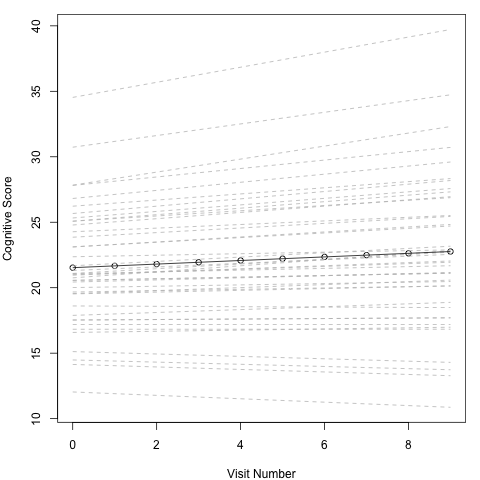

In [27]:
%%R
par(mar = c(4,4,1,1))
# extract model coefficients
ind.effects <- coef(model.rand.slope)$ID
mean.effects <- coef(summary(model.rand.slope))[,"Estimate"]

# create x variable that covers visit numbers
x.sample <- as.matrix(c(0:9))

# predict outcome using individual level coefficients
y.ind <- ind.effects[,1]+ t(x.sample %*% t(as.matrix(ind.effects[,2])))
# predict outcome using overal mean effect coefficients
y.mean <- mean.effects[1] + x.sample * mean.effects[2]

y_lim <-range(y.ind)
plot(x.sample, y.mean, ylim = y_lim, xlab = "Visit Number", ylab = "Cognitive Score")
for(i in 1:nrow(y.ind)){
    lines(x.sample, y.ind[i,], lty = 2, col = "grey")
}
lines(x.sample, y.mean, ylim = y_lim, xlab = "Visit Number", ylab = "Cognitive Score")


In this plot each dashed grey line represents an individual, while the black solid line represents the overall mean effect. What we can see is that each line starts at a different height on the y axis curtesy of the individual specific intercepts. As we saw from the coefficients, each individual has a different slope coefficient, so they are no longer parallel, howevere, that is not obvious to the human eye in this picture. In fact they are only very subtly different, and our significance testing informed us that there was at worst very little variance across individuals. So it is not surprising that we can't see how this manifests in the data. The black line tells us about the average individual, and is what we would use to make predictions about an individual outside of this cohort and describe the effect.

## Assumptions for random slopes model

Random slopes model have all the same assumptions as random intercepts model plus a few more.

-   Linear relationship between predictors and outcomes.
-   Constant variance across range of predictor variables (homoscedasticity).
-   Errors at every level are normally distributed.
-   The level 1 and level 2 residuals are uncorrelated.
-   The errors at the highest level are uncorrelated.
-   The slope residuals for two different groups are uncorrelated.
-   The covariance between the intercept and the slope residual for the same group is $\sigma_{u01}$.
-   The intercept and slope residuals for different groups are uncorrelated.
-   The slope residual is uncorrelated with the level 1 residual.
-   The slope residual is uncorrelated with the covariates.

If our results did suggest that the random slopes model had some value, we could repeat the diagnostic plots from before to check our model assumptions; this time thought we would need to add a fourth plot to check the residuals of the random slope term we estimate for each individual.


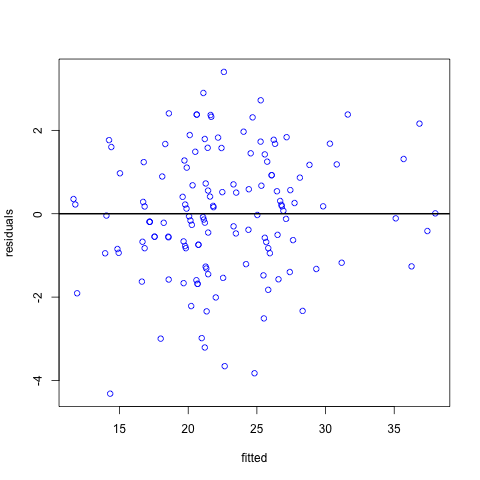

In [28]:
%%R
# a plot to check the constant standard deviation
plot(fitted(model.rand.slope),resid(model.rand.slope,type="pearson"),col="blue", xlab = "fitted", ylab = "residuals") 
abline(h=0,lwd=2)

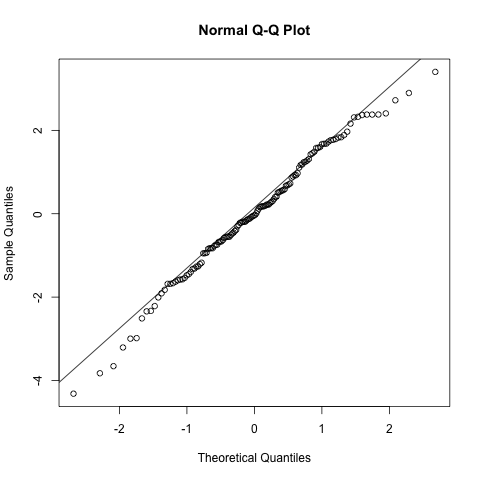

In [29]:
%%R
# normality of the residuals
qqnorm(resid(model.rand.slope)) 
qqline(resid(model.rand.slope))

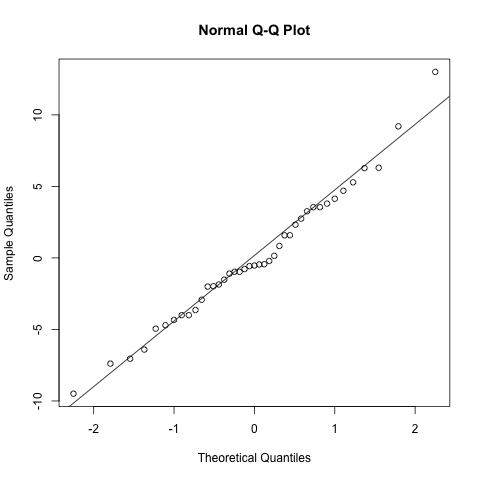

In [30]:
%%R
# normality of the random intercept estimates
qqnorm(ranef(model.rand.slope)$ID[,1]) 
qqline(ranef(model.rand.slope)$ID[,1])

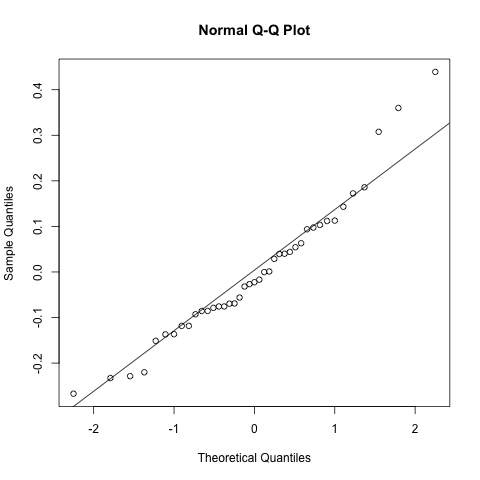

In [31]:
%%R
# normality of the random slope estimates
qqnorm(ranef(model.rand.slope)$ID[,2])
qqline(ranef(model.rand.slope)$ID[,2])

As with the random intercepts model these look pretty reasonable and no reason to believe the model is biased.

## Some notes on model formulation

Once we start incorporating random slopes the interpretation of some predictor variables can get quite complicated. Some things to consider when deciding what model to fit:

-   If we have a random slope, we don't need to have a random intercept.
-   We can have random slopes for continuous, categorical, non-linear or interaction predictor variables.\
-   Where we have multiple predictor variables, we don't have to have random slopes for all the predictor variables - we can be selective in which relationships we think group level effects are relevant for.

## Fixed effects vs random effects

When you have a categorical variable sometimes it can be hard to decide if it should be modeled as a fixed or random effect? This is arguably a subjective decision at times but a few things to consider are:

-   How many groups?
    -   Lots of groups would add lots of variables, so maybe more efficient to estimate variance across effects
-   Do categories have particular meaning?
    -   Can we reassign the ids and not affect the interpretation, if yes a random effect.
-   Do we predict differences (potentially interesting) between the categories?
    -   If yes, fixed effect

Random effects can be thought of as

-   nuisance parameters - we need to model them but we don't care about them (e.g. some artefact of data collection)

OR

-   they may be of particular interest

In general, sample size is a bigger issue for mixed effects models compared to standard regression models, as data feature multiple levels. The level-2 sample size (i.e. number of groups) is the most important factor for determining whether the model will be afflicted by small sample issues.